In [7]:
# 1° Step: How the tree was built?
set.seed(1)

rm(list = ls())
install.packages("grf")
install.packages("Hmisc")


  There is a binary version available but the source version is later:
    binary source needs_compilation
grf  1.2.0  2.0.2              TRUE

  Binaries will be installed


Warning message:
"package 'grf' is in use and will not be installed"


  There is a binary version available but the source version is later:
      binary source needs_compilation
Hmisc  4.5-0  4.6-0              TRUE

  Binaries will be installed


Warning message:
"package 'Hmisc' is in use and will not be installed"

In [8]:
library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

In [9]:

data.all = read.csv("synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

In [10]:
DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [11]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [12]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

In [13]:
C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)

In [14]:
# Grow a forest. Add extra trees for the causal forest.
Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions
# The endogenous variable Y is being used (which means according to the Readme ....),
# the X (the covariates ...) and the W (the dummy variable that represents the treatment)

In [15]:
cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

In [16]:
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions
# We have built the tree with a machine learning algorithm known as decision tree 
# learning to be able to identify an optimal strategy,
# so we can divide the observed individuals into groups to estimate 
# the heterogeneous effects of the treatment.

In [17]:
# 2° Step: Estimate ATE
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))
# The average treatment effect (ATE) that is 0.247
# Has a confidence interval between 0.0210 and 0.286 (+/-0.04) with a 95/% confidence.
# ATE is found through the mean of the distribution of the heterogeneous
# effects distributions that we have found,
# from the sample we have constructed various subgroups, 
# and in each subgroup there is a conditional average treatment effect in each subgroup.

[1] "95% CI for the ATE: 0.247 +/- 0.04"

In [18]:
# 3° Step: Run best linear predictor analysis
test_calibration(cf)



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.999850   0.082656 12.0966 <2e-16 ***
differential.forest.prediction 0.133496   0.609307  0.2191 0.4133    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [19]:
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))

[1] "95% CI for difference in ATE: 0.038 +/- 0.073"

In [20]:
# formal test for X1 and X2
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

In [21]:
school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0771, df = 72.115, p-value = 0.002954
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19481944 -0.04163829
sample estimates:
mean of x mean of y 
0.1882867 0.3065156 


In [22]:
school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])


	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 1.0768, df = 71.819, p-value = 0.2852
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03711945  0.12431855
sample estimates:
mean of x mean of y 
0.2692009 0.2256014 


In [23]:
school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0884 0.04421   1.433  0.245
Residuals        73 2.2528 0.03086               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2462, df = 75, p-value = 0.02763
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009652542 0.160978331
sample estimates:
 mean of x 
0.08531544 


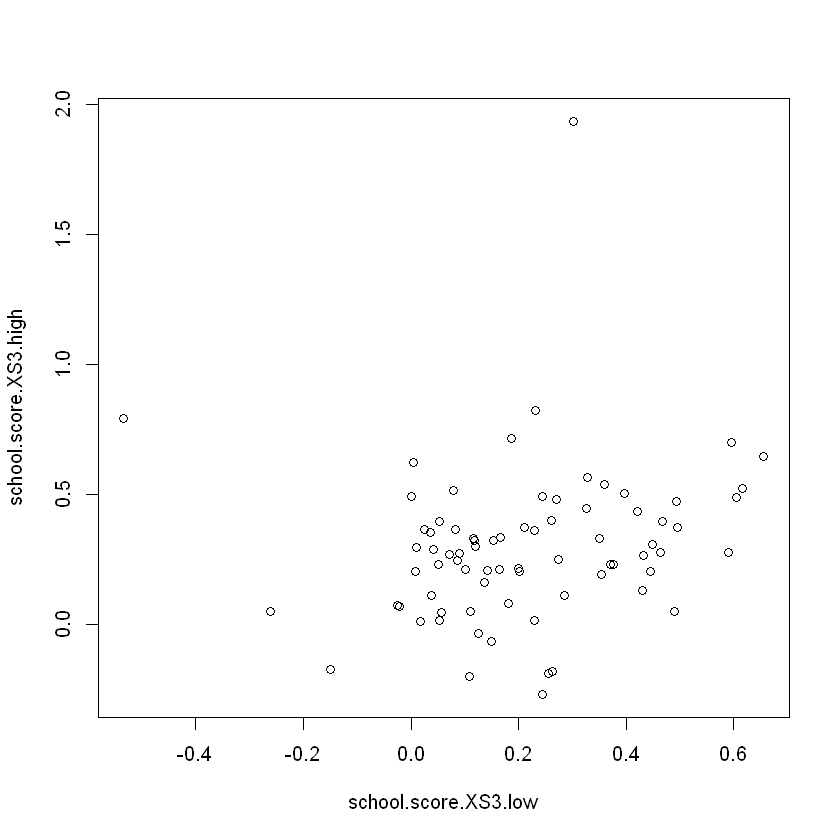

In [48]:
# formal test for S3
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)


pdf 
  3

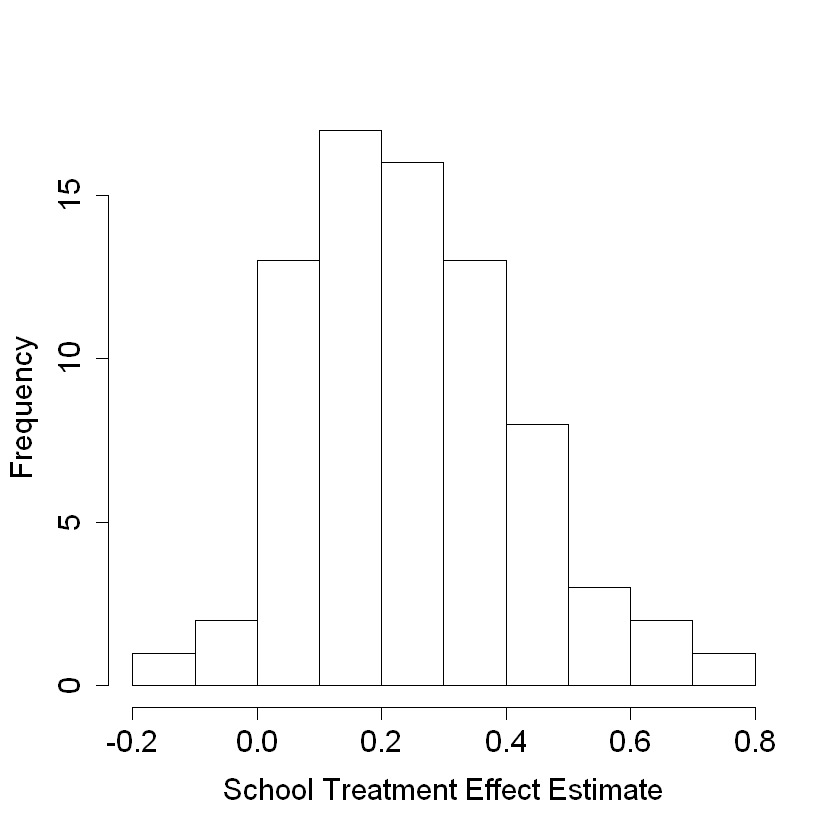

In [49]:
# 4° Step: Look at school-wise heterogeneity

pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()
# distribution graph is the distribution of the heterogeneous effects that we have found

In [50]:
# Re-check ATE... sanity check only
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.247 +/- 0.04"


In [51]:
# Look at variation in propensity scores
DF = X
DF$W.hat = cf$W.hat

pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

png 
  2

In [52]:
# 5° Step: Analysis ignoring clusters. How do the results change?
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

[1] "95% CI for the ATE: 0.253 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.009199   0.045041 22.4062 < 2.2e-16 ***
differential.forest.prediction 0.503301   0.122801  4.0985 2.095e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


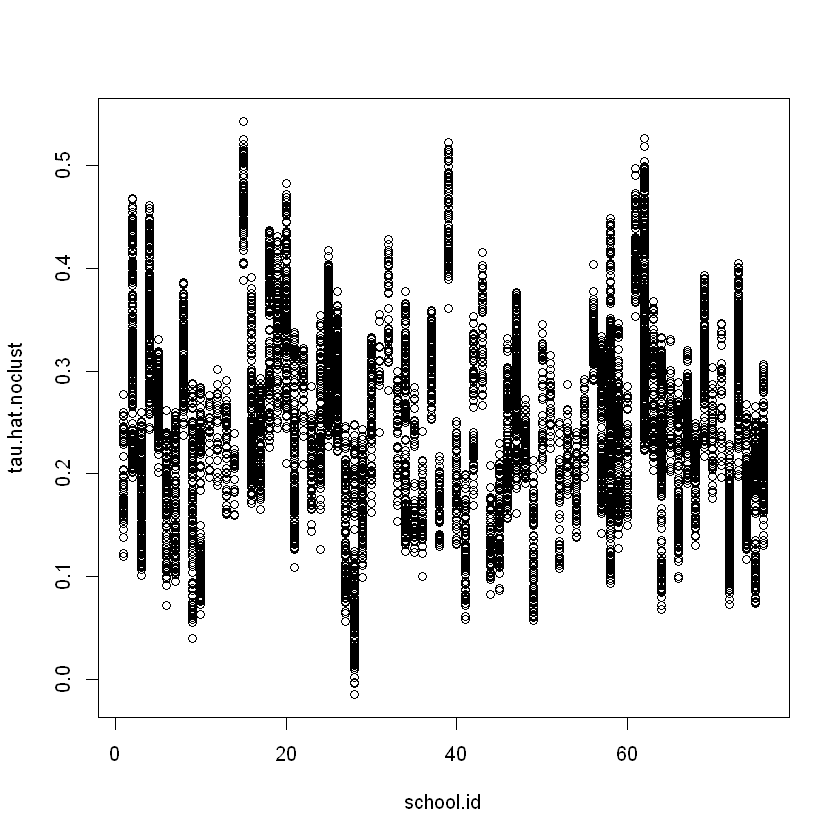

In [53]:
test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

In [60]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.985665   0.065229 15.1107 <2e-16 ***
differential.forest.prediction 0.209269   0.223759  0.9352 0.1748    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [62]:
install.packages("survival")
install.packages("lattice")
install.packages("ggplot2")
install.packages("Hmisc")

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)


  There is a binary version available but the source version is later:
         binary source needs_compilation
survival 3.2-11 3.2-13              TRUE

  Binaries will be installed


Warning message:
"package 'survival' is in use and will not be installed"


  There is a binary version available but the source version is later:
         binary  source needs_compilation
lattice 0.20-44 0.20-45              TRUE

  Binaries will be installed


Warning message:
"package 'lattice' is in use and will not be installed"also installing the dependencies 'isoband', 'rlang'




  There are binary versions available but the source versions are later:
        binary source needs_compilation
isoband  0.2.4  0.2.5              TRUE
rlang   0.4.11 0.4.12              TRUE
ggplot2  3.3.3  3.3.5             FALSE

  Binaries will be installed
package 'isoband' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\CARLOS\anaconda3\envs\renv\Lib\R\library\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\CARLOS\anaconda3\envs\renv\Lib\R\library\rlang\libs\x64\rlang.dll: Permission denied"Warning message:
"restored 'rlang'"


The downloaded binary packages are in
	C:\Users\CARLOS\AppData\Local\Temp\RtmpOwDsxX\downloaded_packages


installing the source package 'ggplot2'

Warning message in install.packages("ggplot2"):
"installation of package 'ggplot2' had non-zero exit status"


  There is a binary version available but the source version is later:
      binary source needs_compilation
Hmisc  4.5-0  4.6-0              TRUE

  Binaries will be installed


Warning message:
"package 'Hmisc' is in use and will not be installed"

[1] -2.789672e-05  4.984980e-04

In [56]:
summary(aov(dr.score ~ factor(school.id)))

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    204   2.719   1.999 7.31e-07 ***
Residuals         10315  14026   1.360                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [63]:
# 6° Step: Analysis without fitting the propensity score
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

[1] "95% CI for the ATE: 0.255 +/- 0.04"

In [64]:
pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

In [36]:
# Train forest on school-wise DR scores
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.996046   0.082429 12.0837 <2e-16 ***
differential.forest.prediction 0.735856   0.647994  1.1356 0.1299    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [65]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2462869  0.0754265  3.2653 0.001736 **
X1          -0.0503416  0.0293343 -1.7161 0.090828 . 
X2           0.0160023  0.0337751  0.4738 0.637213   
X3           0.0107538  0.0266021  0.4042 0.687340   
X4           0.0241594  0.0256098  0.9434 0.348935   
X5          -0.0355428  0.0266988 -1.3313 0.187686   
XC.1        -0.0052089  0.0914657 -0.0569 0.954758   
XC.2         0.0797300  0.1036885  0.7689 0.444673   
XC.3        -0.1397294  0.0858393 -1.6278 0.108332   
XC.4         0.0381012  0.0811036  0.4698 0.640058   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [72]:
# 7° Step: Six plots and their explanation
pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

png 
  2

In [75]:
pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()

png 
  2

In [76]:
pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
dev.off()

ERROR: Error in hist.default(tau.hat.noclust, xlab = "estimated CATE", main = "", : some 'x' not counted; maybe 'breaks' do not span range of 'x'


In [77]:
pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)

In [78]:
pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)

In [79]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

In [80]:
pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

In [81]:
# Experiment with no orthogonalization
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: 0.099 +/- 0.149"

[1] "95% CI for the ATE: 0.194 +/- 0.136"

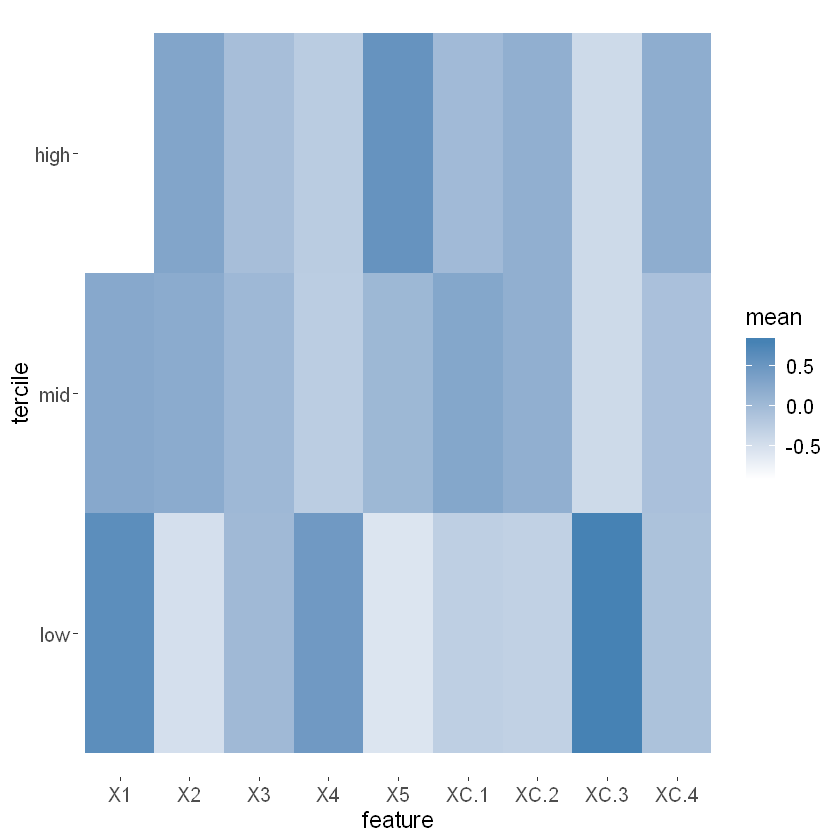

In [82]:
#Step 8: Visualize school-level covariates by treatment heterogeneity
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

In [83]:
mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])


[1] 0.2105263

[1] 0.5384615

In [84]:
# 9° Step: CATE by school
ord = order(order(school.pred))
school.sort = ord[school.id]

pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

png 
  2